In [10]:
import os 
from langchain_openai import AzureChatOpenAI
import dotenv
from typing import TypedDict
from langgraph.graph import StateGraph, START, END 


dotenv.load_dotenv()


llm = AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OpenAI_API_VERSION_3"),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_3'),
    model_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_3'),
    api_key=os.getenv('OPENAI_API_KEY_3'),
    azure_endpoint=os.getenv('AZURE_OpenAI_ENDPOINT_3')
   )

llm.invoke('hello').content

'Hello! How can I assist you today? 😊'

In [11]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
class Route(BaseModel):
    step: Literal['poem','story','joke']=Field(
        None, description='The next step in the rounting process'
    )

# Augment the LLM with schema for structured output 
router=llm.with_structured_output(Route)

In [ ]:
# State 
class State(TypedDict):
    input: str
    decision: str
    output: str 
     

In [28]:
from langchain_core.messages import HumanMessage, SystemMessage

def write_story(state:State):
    result=llm.invoke(state['input'])
    return {'output':result.content}

def write_poem(state:State):
    result=llm.invoke(state['input'])
    return {'output':result.content}

def write_joke(state:State):
    result=llm.invoke(state['input'])
    return {'output':result.content}

def call_route(state:State):
    decision=router.invoke(
        [
            SystemMessage(
                content='Route the input to story,joke or poem based on the users request'
            ),
            HumanMessage(content=state['input'])
        ]
    )
    return {'decision':decision.step}


def route_decision(state:State):
    if state['decision']=='story':
        return 'story'
    elif state['decision']=='poem':
        return 'poem'
    elif state['decision']=='joke':
        return 'joke'

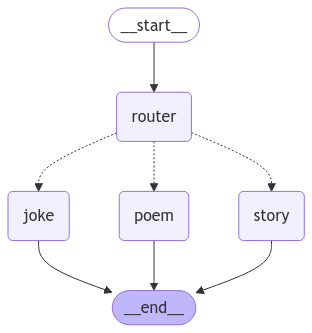

In [29]:
# build workflow 
router_builder=StateGraph(State)

# nodes 
router_builder.add_node('router',call_route)
router_builder.add_node('story',write_story)
router_builder.add_node('poem',write_poem)
router_builder.add_node('joke',write_joke)


# add edges 
router_builder.add_edge(START,'router')
router_builder.add_conditional_edges(
    'router',
    route_decision,
    {
        'story':'story',
        'poem':'poem',
        'joke':'joke',
    },
)

router_builder.add_edge('story',END)
router_builder.add_edge('poem',END)
router_builder.add_edge('joke',END)

graph=router_builder.compile()
graph

In [32]:
state=graph.invoke({'input':'write me a story about superman with DC vs Marvel reference'})
state

{'input': 'write me a story about superman with DC vs Marvel reference',
 'decision': 'story',
 'output': 'Certainly! Here\'s a story that weaves classic elements of Superman and the DC Universe with an exciting twist featuring Marvel characters:\n\n---\n\n**"Worlds Collide: The Last Son vs. The Universe Next Door"**\n\nThe sun hung low over Metropolis, casting golden hues across the steel and glass of the bustling city. In the heart of the city stood Clark Kent, better known to the world as Superman, perched atop the Daily Planet building. His signature red cape billowed in the wind as his piercing gaze scanned the horizon, searching for threats. Lately, the Man of Steel had felt a strange disturbance—not in the city, but in… everything.\n\n"Clark," came a voice over his comm-link. It was Bruce Wayne, Batman himself. "Do you feel it too?"\n\nSuperman’s jaw tightened. "Yes. Something’s off. It’s... like the fabric of reality is shifting, like two worlds are pressing against each other.